In [2]:
from sklearn.model_selection import train_test_split
#input the good csv and the bad csv
def load_data(file):
    x=[]
    data = pd.read_csv(file, sep="\n",header=None)
    x=[i[0] for i in data.values]
    return x
good = load_data("good.csv")
bad = load_data("bad.csv")
X=good+bad
Y=[0]*len(good)+[1]*len(bad)
print(len(good))
print(len(bad))

344821
77356


In [3]:
data = []
labels = []

length = len(bad)
scale = 3
data.extend(good[:length * scale]) 
data.extend(bad)
labels.extend([1] * length * scale)
labels.extend([0] * length)
print('data:', len(data))
print(data[0], data[-1])

data: 309424
01453.com/ photoscape.ch/Setup.exe


In [4]:
MAX_SEQUENCE_LENGTH = 200 # 句子 上限200个词
EMBEDDING_DIM = 100 # 100d 词向量
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 文本预处理
# tokenizer
texts = data
tokenizer = Tokenizer(char_level=True) # 字向量，每个字符都会被标记
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index #将字符串映射为排名或索引

# sequences
sequences = tokenizer.texts_to_sequences(data) #将一个句子拆分成单词构成的列表

# padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #确定最大长度

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)

Found 171 unique tokens.
Shape of data tensor: (309424, 200)


In [5]:
import pickle
# 将数据预处理的模型保存
token_path = 'tokenizer.pkl'
pickle.dump(tokenizer, open(token_path, 'wb'))

In [6]:
import random

# 打乱顺序
index = [i for i in range(len(data))]
random.shuffle(index)
data = np.array(data)[index]
labels = np.array(labels)[index]

TRAIN_SPLIT = 0.8 # 选的80%为训练集，20%为测试集
TRAIN_SIZE = int(len(data) * TRAIN_SPLIT)

X_train, X_test = data[0:TRAIN_SIZE], data[TRAIN_SIZE:]
Y_train, Y_test = labels[0:TRAIN_SIZE], labels[TRAIN_SIZE:]

In [7]:
print('train len:', len(X_train))
print('test len:', len(X_test))

train len: 247539
test len: 61885


In [8]:
import tensorflow as tf
from keras import backend as K
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)

In [9]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional

QA_EMBED_SIZE = 64
DROPOUT_RATE = 0.3

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# 加入双向的LSTM层
model.add(Bidirectional(LSTM(QA_EMBED_SIZE, return_sequences=False, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)))
# 添加全连接层，输出维度为64维
model.add(Dense(QA_EMBED_SIZE))
# 添加标准化层
model.add(BatchNormalization())
# 激活层，激活函数选择relu
model.add(Activation('relu'))
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          17200     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

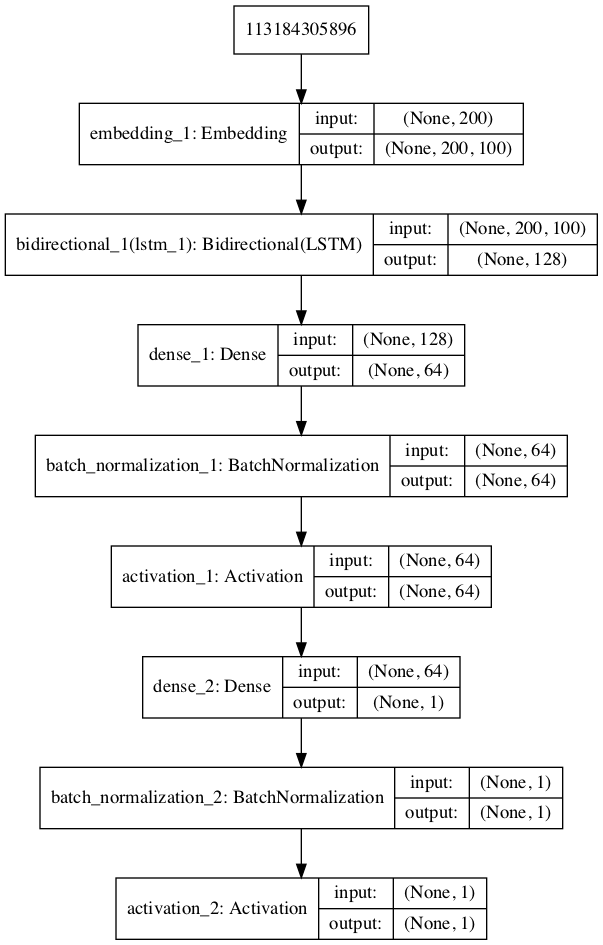

In [11]:
from keras.utils import plot_model
from IPython import display
# 模型可视化
plot_model(model, to_file="model-bilstm.png", show_shapes=True)
display.Image('model-bilstm.png')

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


EPOCHS = 3
BATCH_SIZE = 64 * G
VALIDATION_SPLIT = 0.3 # 30% 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('model-blstm.h5', save_best_only=True, save_weights_only=True)
tensor_board = TensorBoard('log/tflog-blstm', write_graph=True, write_images=True)


model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VALIDATION_SPLIT, shuffle=True, 
          callbacks=[early_stopping, model_checkpoint, tensor_board])

Instructions for updating:
Use tf.cast instead.
Train on 173277 samples, validate on 74262 samples
Epoch 1/3
173277/173277 [==============================] - 2871s 17ms/step - loss: 0.3396 - acc: 0.8737 - val_loss: 0.2123 - val_acc: 0.9233
Epoch 2/3
173277/173277 [==============================] - 2610s 15ms/step - loss: 0.2063 - acc: 0.9242 - val_loss: 0.1633 - val_acc: 0.9417
Epoch 3/3
173277/173277 [==============================] - 2583s 15ms/step - loss: 0.1675 - acc: 0.9397 - val_loss: 0.1343 - val_acc: 0.9523


In [15]:
model.evaluate(X_test, Y_test, verbose=1, batch_size=BATCH_SIZE)


61885/61885 [==============================] - 229s 4ms/step


[0.12946242409454048, 0.9546416740921402]

从上面的结果可以看到，该模型的损失值是0.1295，精度为95.46%